# Dataset Augmentation for CLIP Fine-Tuning

This notebook enriches the training dataset with:

1. **Image Augmentation** — Generate additional positive pairs via realistic image transforms
2. **Text Augmentation** — Create caption variations while preserving semantic meaning
3. **Negative Pair Generation** — Mismatch images and captions from different recipes

**Input:** 
- `fine-tuning-zone/datasets/train_pairs_positive.csv`
- `fine-tuning-zone/images/` (original images)

**Output:**
- `fine-tuning-zone/datasets/train_pairs_augmented_with_negatives.csv`
- `fine-tuning-zone/augmented_images/` (augmented images stored here)

The final dataset will have columns:
- `recipe_id`
- `image_key` (points to images/ or augmented_images/)
- `caption`
- `label` (1 = positive, 0 = negative)

## 1. Setup and Configuration

In [59]:
import os
import io
import random
import re
from pathlib import Path
from typing import Dict, List, Optional, Tuple

import yaml
import numpy as np
import pandas as pd
from PIL import Image
import boto3
from botocore.config import Config
from botocore.exceptions import ClientError
from dotenv import load_dotenv

# Image augmentation
try:
    import torchvision.transforms as T
    TORCHVISION_AVAILABLE = True
except ImportError:
    TORCHVISION_AVAILABLE = False
    print("⚠ torchvision not available, using PIL-based augmentations")

# Load environment variables
NOTEBOOK_DIR = Path.cwd()
PROJECT_ROOT = NOTEBOOK_DIR.parent.parent

ENV_PATHS = [
    PROJECT_ROOT / "notebooks" / ".env",
    PROJECT_ROOT / "app" / ".env",
    PROJECT_ROOT / ".env",
]

env_loaded = False
for env_path in ENV_PATHS:
    if env_path.exists():
        load_dotenv(env_path)
        print(f"✓ Loaded .env from: {env_path}")
        env_loaded = True
        break

if not env_loaded:
    print("⚠ No .env file found, trying default load_dotenv()...")
    load_dotenv()

# MinIO Configuration
MINIO_USER = os.getenv("MINIO_USER")
MINIO_PASSWORD = os.getenv("MINIO_PASSWORD")
MINIO_ENDPOINT = os.getenv("MINIO_ENDPOINT")

# Bucket configuration
TRUSTED_BUCKET = "trusted-zone"
FINE_TUNING_BUCKET = "fine-tuning-zone"
DATASETS_PREFIX = "datasets"
IMAGES_PREFIX = "images"                    # Original images copied from trusted zone
AUGMENTED_IMAGES_PREFIX = "augmented_images"  # Augmented images stored here

# Input/Output paths
TRAIN_INPUT_KEY = f"{DATASETS_PREFIX}/train_pairs_positive.csv"
OUTPUT_KEY = f"{DATASETS_PREFIX}/train_pairs_augmented_with_negatives.csv"

# Augmentation settings
RANDOM_SEED = 42
IMAGE_AUGMENTATIONS_PER_SAMPLE = 2  # Number of augmented images per original
TEXT_AUGMENTATIONS_PER_SAMPLE = 1   # Number of augmented captions per original
NEGATIVES_PER_POSITIVE = 1          # Number of negative pairs per positive

# Set random seeds for reproducibility
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

print(f"\nConfiguration:")
print(f"  MinIO Endpoint: {MINIO_ENDPOINT}")
print(f"  Fine-tuning Bucket: {FINE_TUNING_BUCKET}")
print(f"  Image augmentations per sample: {IMAGE_AUGMENTATIONS_PER_SAMPLE}")
print(f"  Text augmentations per sample: {TEXT_AUGMENTATIONS_PER_SAMPLE}")
print(f"  Negatives per positive: {NEGATIVES_PER_POSITIVE}")

✓ Loaded .env from: /Users/dcayuela/Desktop/UPC/ADSDB/ADSDB_Project_Team1_2nd_delivery/adsdb-multimodal-food-data-management/notebooks/.env

Configuration:
  MinIO Endpoint: http://localhost:9000
  Fine-tuning Bucket: fine-tuning-zone
  Image augmentations per sample: 2
  Text augmentations per sample: 1
  Negatives per positive: 1


In [60]:
# Initialize S3/MinIO client
session = boto3.session.Session(
    aws_access_key_id=MINIO_USER,
    aws_secret_access_key=MINIO_PASSWORD,
    region_name="us-east-1"
)
s3 = session.client(
    "s3",
    endpoint_url=MINIO_ENDPOINT,
    config=Config(signature_version="s3v4", s3={"addressing_style": "path"})
)

def ensure_bucket_exists(bucket: str) -> bool:
    """Create bucket if it doesn't exist."""
    try:
        s3.head_bucket(Bucket=bucket)
        return True
    except ClientError as e:
        error_code = e.response.get("Error", {}).get("Code", "")
        if error_code in ("404", "NoSuchBucket"):
            try:
                s3.create_bucket(Bucket=bucket)
                print(f"✓ Created bucket '{bucket}'")
                return True
            except ClientError as create_error:
                print(f"✗ Failed to create bucket '{bucket}': {create_error}")
                return False
        return False

# Verify buckets
print("Checking buckets...")
ensure_bucket_exists(FINE_TUNING_BUCKET)
ensure_bucket_exists(TRUSTED_BUCKET)
print("✓ Buckets ready")

Checking buckets...
✓ Buckets ready


## 2. Load Training Data

In [61]:
def load_csv_from_minio(bucket: str, key: str) -> pd.DataFrame:
    """Load CSV file from MinIO into a DataFrame."""
    try:
        obj = s3.get_object(Bucket=bucket, Key=key)
        df = pd.read_csv(io.BytesIO(obj["Body"].read()))
        print(f"✓ Loaded {len(df)} rows from s3://{bucket}/{key}")
        return df
    except ClientError as e:
        print(f"✗ Failed to load s3://{bucket}/{key}: {e}")
        return pd.DataFrame()

# Load training pairs
train_df = load_csv_from_minio(FINE_TUNING_BUCKET, TRAIN_INPUT_KEY)

if train_df.empty:
    raise RuntimeError(f"Could not load training data from s3://{FINE_TUNING_BUCKET}/{TRAIN_INPUT_KEY}")

print(f"\nDataset shape: {train_df.shape}")
print(f"Unique recipes: {train_df['recipe_id'].nunique()}")
print(f"Unique images: {train_df['image_key'].nunique()}")
print(f"\nSample data:")
display(train_df.head())

✓ Loaded 372 rows from s3://fine-tuning-zone/datasets/train_pairs_positive.csv

Dataset shape: (372, 3)
Unique recipes: 216
Unique images: 372

Sample data:


,recipe_id,image_key,caption
0,004205a8a0,images/image$adsdb-multimodal-food-data-manage...,Banana French Toast
1,004205a8a0,images/image$adsdb-multimodal-food-data-manage...,Banana French Toast
2,004205a8a0,images/image$adsdb-multimodal-food-data-manage...,Banana French Toast
3,004205a8a0,images/image$adsdb-multimodal-food-data-manage...,Banana French Toast
4,004205a8a0,images/image$adsdb-multimodal-food-data-manage...,Banana French Toast


## 3. Image Augmentation

Apply realistic augmentations to training images:
- Horizontal flip
- Random crop/resize
- Color jitter
- Small rotation
- Gaussian noise

Augmented images are saved to `fine-tuning-zone/augmented_images/` in MinIO.

In [62]:
from PIL import ImageFilter, ImageEnhance

# Load augmentation config
CONFIG_PATH = Path("augmentation_config.yaml")

def load_augmentation_config(config_path: Path) -> dict:
    """Load augmentation configuration from YAML file."""
    if config_path.exists():
        with open(config_path, "r") as f:
            config = yaml.safe_load(f)
        print(f"✓ Loaded augmentation config from: {config_path}")
        return config
    else:
        print(f"⚠ Config not found at {config_path}, using defaults")
        return {}

AUG_CONFIG = load_augmentation_config(CONFIG_PATH)


class ImageAugmenter:
    """Image augmentation pipeline for CLIP fine-tuning with configurable parameters."""
    
    def __init__(self, config: dict = None):
        self.config = config.get("image_augmentation", {}) if config else {}
        
        # Target size
        target_size = self.config.get("target_size", [512, 512])
        self.target_size = tuple(target_size)
        
        # Crop config
        crop_cfg = self.config.get("crop", {})
        self.crop_min_ratio = crop_cfg.get("min_ratio", 0.70)
        self.crop_max_ratio = crop_cfg.get("max_ratio", 0.90)
        
        # Color config
        color_cfg = self.config.get("color", {})
        self.brightness_range = color_cfg.get("brightness_range", [0.7, 1.3])
        self.contrast_range = color_cfg.get("contrast_range", [0.7, 1.3])
        self.saturation_range = color_cfg.get("saturation_range", [0.6, 1.4])
        
        # Rotation config
        rot_cfg = self.config.get("rotation", {})
        slight_cfg = rot_cfg.get("slight", {})
        self.rotation_min = slight_cfg.get("min_angle", -25)
        self.rotation_max = slight_cfg.get("max_angle", 25)
        self.fill_color = tuple(rot_cfg.get("fill_color", [128, 128, 128]))
        
        # Noise config
        noise_cfg = self.config.get("noise", {})
        self.noise_std_min = noise_cfg.get("std_min", 15)
        self.noise_std_max = noise_cfg.get("std_max", 35)
        
        # Blur config
        blur_cfg = self.config.get("blur", {})
        self.blur_radius_min = blur_cfg.get("radius_min", 0.5)
        self.blur_radius_max = blur_cfg.get("radius_max", 2.0)
        
        # Build augmentation dictionary based on enabled transforms
        self.augmentations = {}
        
        if self.config.get("hflip", {}).get("enabled", True):
            self.augmentations["hflip"] = self._horizontal_flip
        
        if self.config.get("vflip", {}).get("enabled", True):
            self.augmentations["vflip"] = self._vertical_flip
        
        if self.config.get("crop", {}).get("enabled", True):
            self.augmentations["crop"] = self._random_crop_resize
        
        if self.config.get("color", {}).get("enabled", True):
            self.augmentations["color"] = self._color_jitter
        
        # Multiple rotation types
        rot_cfg = self.config.get("rotation", {})
        if rot_cfg.get("enabled", True):
            if rot_cfg.get("slight", {}).get("enabled", True):
                self.augmentations["rotate_slight"] = self._slight_rotation
            if rot_cfg.get("rotate_90", {}).get("enabled", True):
                self.augmentations["rotate_90"] = self._rotate_90
            if rot_cfg.get("rotate_180", {}).get("enabled", True):
                self.augmentations["rotate_180"] = self._rotate_180
            if rot_cfg.get("rotate_270", {}).get("enabled", True):
                self.augmentations["rotate_270"] = self._rotate_270
        
        if self.config.get("noise", {}).get("enabled", True):
            self.augmentations["noise"] = self._gaussian_noise
        
        if self.config.get("blur", {}).get("enabled", True):
            self.augmentations["blur"] = self._gaussian_blur
    
    def _horizontal_flip(self, img: Image.Image) -> Image.Image:
        """Flip image horizontally."""
        return img.transpose(Image.FLIP_LEFT_RIGHT)
    
    def _vertical_flip(self, img: Image.Image) -> Image.Image:
        """Flip image vertically."""
        return img.transpose(Image.FLIP_TOP_BOTTOM)
    
    def _random_crop_resize(self, img: Image.Image) -> Image.Image:
        """Random crop and resize back to target size."""
        w, h = img.size
        crop_ratio = random.uniform(self.crop_min_ratio, self.crop_max_ratio)
        new_w, new_h = int(w * crop_ratio), int(h * crop_ratio)
        left = random.randint(0, w - new_w)
        top = random.randint(0, h - new_h)
        cropped = img.crop((left, top, left + new_w, top + new_h))
        return cropped.resize(self.target_size, Image.BICUBIC)
    
    def _color_jitter(self, img: Image.Image) -> Image.Image:
        """Apply color adjustments with configurable intensity."""
        # Brightness
        enhancer = ImageEnhance.Brightness(img)
        img = enhancer.enhance(random.uniform(*self.brightness_range))
        
        # Contrast
        enhancer = ImageEnhance.Contrast(img)
        img = enhancer.enhance(random.uniform(*self.contrast_range))
        
        # Saturation
        enhancer = ImageEnhance.Color(img)
        img = enhancer.enhance(random.uniform(*self.saturation_range))
        
        return img
    
    def _slight_rotation(self, img: Image.Image) -> Image.Image:
        """Rotate image by a random small angle."""
        angle = random.uniform(self.rotation_min, self.rotation_max)
        return img.rotate(angle, resample=Image.BICUBIC, expand=False, fillcolor=self.fill_color)
    
    def _rotate_90(self, img: Image.Image) -> Image.Image:
        """Rotate image 90 degrees clockwise."""
        return img.rotate(-90, resample=Image.BICUBIC, expand=False)
    
    def _rotate_180(self, img: Image.Image) -> Image.Image:
        """Rotate image 180 degrees."""
        return img.rotate(180, resample=Image.BICUBIC, expand=False)
    
    def _rotate_270(self, img: Image.Image) -> Image.Image:
        """Rotate image 270 degrees clockwise (90 counter-clockwise)."""
        return img.rotate(-270, resample=Image.BICUBIC, expand=False)
    
    def _gaussian_noise(self, img: Image.Image) -> Image.Image:
        """Add Gaussian noise with configurable intensity."""
        arr = np.array(img).astype(np.float32)
        noise_std = random.uniform(self.noise_std_min, self.noise_std_max)
        noise = np.random.normal(0, noise_std, arr.shape)
        noisy = np.clip(arr + noise, 0, 255).astype(np.uint8)
        return Image.fromarray(noisy)
    
    def _gaussian_blur(self, img: Image.Image) -> Image.Image:
        """Apply Gaussian blur with configurable radius."""
        radius = random.uniform(self.blur_radius_min, self.blur_radius_max)
        return img.filter(ImageFilter.GaussianBlur(radius=radius))
    
    def get_random_augmentations(self, n: int = 2) -> List[str]:
        """Get n random augmentation names."""
        aug_names = list(self.augmentations.keys())
        return random.sample(aug_names, min(n, len(aug_names)))
    
    def augment(self, img: Image.Image, aug_name: str) -> Image.Image:
        """Apply a specific augmentation."""
        if aug_name in self.augmentations:
            return self.augmentations[aug_name](img)
        return img
    
    def print_config(self):
        """Print current augmentation configuration."""
        print("Image Augmentation Configuration:")
        print(f"  Target size: {self.target_size}")
        print(f"  Crop ratio: [{self.crop_min_ratio}, {self.crop_max_ratio}]")
        print(f"  Brightness: {self.brightness_range}")
        print(f"  Contrast: {self.contrast_range}")
        print(f"  Saturation: {self.saturation_range}")
        print(f"  Rotation range: [{self.rotation_min}°, {self.rotation_max}°]")
        print(f"  Noise std: [{self.noise_std_min}, {self.noise_std_max}]")
        print(f"  Blur radius: [{self.blur_radius_min}, {self.blur_radius_max}]")
        print(f"  Enabled augmentations: {list(self.augmentations.keys())}")


# Initialize augmenter with config
augmenter = ImageAugmenter(config=AUG_CONFIG)
augmenter.print_config()

✓ Loaded augmentation config from: augmentation_config.yaml
Image Augmentation Configuration:
  Target size: (512, 512)
  Crop ratio: [0.7, 0.9]
  Brightness: [0.7, 1.3]
  Contrast: [0.7, 1.3]
  Saturation: [0.6, 1.4]
  Rotation range: [-25°, 25°]
  Noise std: [15, 35]
  Blur radius: [0.5, 2.0]
  Enabled augmentations: ['hflip', 'vflip', 'crop', 'color', 'rotate_slight', 'rotate_90', 'rotate_180', 'rotate_270', 'noise', 'blur']


In [63]:
def load_image_from_minio(bucket: str, key: str) -> Optional[Image.Image]:
    """Load an image from MinIO."""
    try:
        obj = s3.get_object(Bucket=bucket, Key=key)
        img = Image.open(io.BytesIO(obj["Body"].read()))
        img.load()
        return img.convert("RGB")
    except Exception as e:
        return None


def save_image_to_minio(img: Image.Image, bucket: str, key: str) -> bool:
    """Save an image to MinIO."""
    try:
        buf = io.BytesIO()
        img.save(buf, format="JPEG", quality=90)
        buf.seek(0)
        s3.put_object(Bucket=bucket, Key=key, Body=buf.getvalue(), ContentType="image/jpeg")
        return True
    except Exception as e:
        return False


def generate_augmented_image_key(original_key: str, aug_name: str, idx: int, prefix: str) -> str:
    """Generate a new key for an augmented image in the augmented_images folder."""
    from pathlib import PurePosixPath
    # Extract just the filename from the original key
    filename = PurePosixPath(original_key).name
    # Remove extension and add augmentation suffix
    base = filename.rsplit(".", 1)[0]
    return f"{prefix}/{base}_aug_{aug_name}_{idx}.jpg"


def create_image_augmentations(
    df: pd.DataFrame,
    bucket: str,
    augmented_prefix: str,
    n_augmentations: int = 2,
    sample_fraction: float = 1.0
) -> pd.DataFrame:
    """
    Create augmented images and store them in MinIO.
    
    For each image, applies n_augmentations random transforms and saves
    the augmented images to the augmented_images folder in MinIO.
    
    Args:
        df: Original training DataFrame
        bucket: MinIO bucket to store augmented images
        augmented_prefix: Prefix for augmented images (e.g., 'augmented_images')
        n_augmentations: Number of augmentations per image
        sample_fraction: Fraction of images to augment (for efficiency)
    
    Returns:
        DataFrame with augmented image pairs
    """
    augmented_rows = []
    
    # Sample images for augmentation
    if sample_fraction < 1.0:
        sample_df = df.sample(frac=sample_fraction, random_state=RANDOM_SEED)
    else:
        sample_df = df
    
    unique_images = sample_df["image_key"].unique()
    total_images = len(unique_images)
    
    print(f"Generating {n_augmentations} augmentations for {total_images} unique images...")
    print(f"Augmented images will be stored in s3://{bucket}/{augmented_prefix}/")
    
    saved_count = 0
    failed_count = 0
    
    # Process each unique image once
    image_to_augs = {}  # Map original image to list of augmented keys
    
    for img_idx, original_key in enumerate(unique_images):
        if img_idx % 50 == 0:
            print(f"  Processing image {img_idx + 1}/{total_images}...")
        
        # Load the original image from fine-tuning bucket (copied from trusted zone)
        img = load_image_from_minio(bucket, original_key)
        if img is None:
            failed_count += 1
            continue
        
        # Get random augmentation types for this image
        aug_types = augmenter.get_random_augmentations(n_augmentations)
        aug_keys = []
        
        for i, aug_type in enumerate(aug_types):
            # Apply augmentation
            aug_img = augmenter.augment(img, aug_type)
            
            # Generate new key in augmented_images folder
            aug_key = generate_augmented_image_key(original_key, aug_type, i, augmented_prefix)
            
            # Save augmented image to MinIO
            if save_image_to_minio(aug_img, bucket, aug_key):
                aug_keys.append((aug_key, aug_type))
                saved_count += 1
            else:
                failed_count += 1
        
        image_to_augs[original_key] = aug_keys
    
    # Now create DataFrame rows for all pairs
    for idx, row in sample_df.iterrows():
        original_key = row["image_key"]
        aug_keys = image_to_augs.get(original_key, [])
        
        for aug_key, aug_type in aug_keys:
            augmented_rows.append({
                "recipe_id": row["recipe_id"],
                "image_key": aug_key,
                "caption": row["caption"],
                "label": 1,
                "augmentation_type": f"image_{aug_type}",
            })
    
    aug_df = pd.DataFrame(augmented_rows)
    print(f"\n✓ Created {saved_count} augmented images in s3://{bucket}/{augmented_prefix}/")
    print(f"✓ Generated {len(aug_df)} image-augmented pairs")
    return aug_df

# Generate image augmentations and store in MinIO
image_aug_df = create_image_augmentations(
    train_df,
    bucket=FINE_TUNING_BUCKET,
    augmented_prefix=AUGMENTED_IMAGES_PREFIX,
    n_augmentations=IMAGE_AUGMENTATIONS_PER_SAMPLE,
    sample_fraction=1.0  # Augment all images
)

print(f"\nImage augmentation summary:")
if not image_aug_df.empty:
    print(image_aug_df["augmentation_type"].value_counts())
else:
    print("No augmentations generated")

Generating 2 augmentations for 372 unique images...
Augmented images will be stored in s3://fine-tuning-zone/augmented_images/
  Processing image 1/372...
  Processing image 51/372...
  Processing image 101/372...
  Processing image 151/372...
  Processing image 201/372...
  Processing image 251/372...
  Processing image 301/372...
  Processing image 351/372...

✓ Created 744 augmented images in s3://fine-tuning-zone/augmented_images/
✓ Generated 744 image-augmented pairs

Image augmentation summary:
augmentation_type
image_rotate_slight    91
image_vflip            83
image_color            83
image_rotate_180       82
image_rotate_270       81
image_rotate_90        74
image_noise            68
image_hflip            64
image_crop             63
image_blur             55
Name: count, dtype: int64


### 3.1 Visualize Image Augmentations

Compare original images with their augmented versions to verify the augmentation parameters are reasonable.

IMAGE AUGMENTATION PREVIEW
Available augmentations: ['hflip', 'vflip', 'crop', 'color', 'rotate_slight', 'rotate_90', 'rotate_180', 'rotate_270', 'noise', 'blur']

Edit 'augmentation_config.yaml' to adjust parameters.



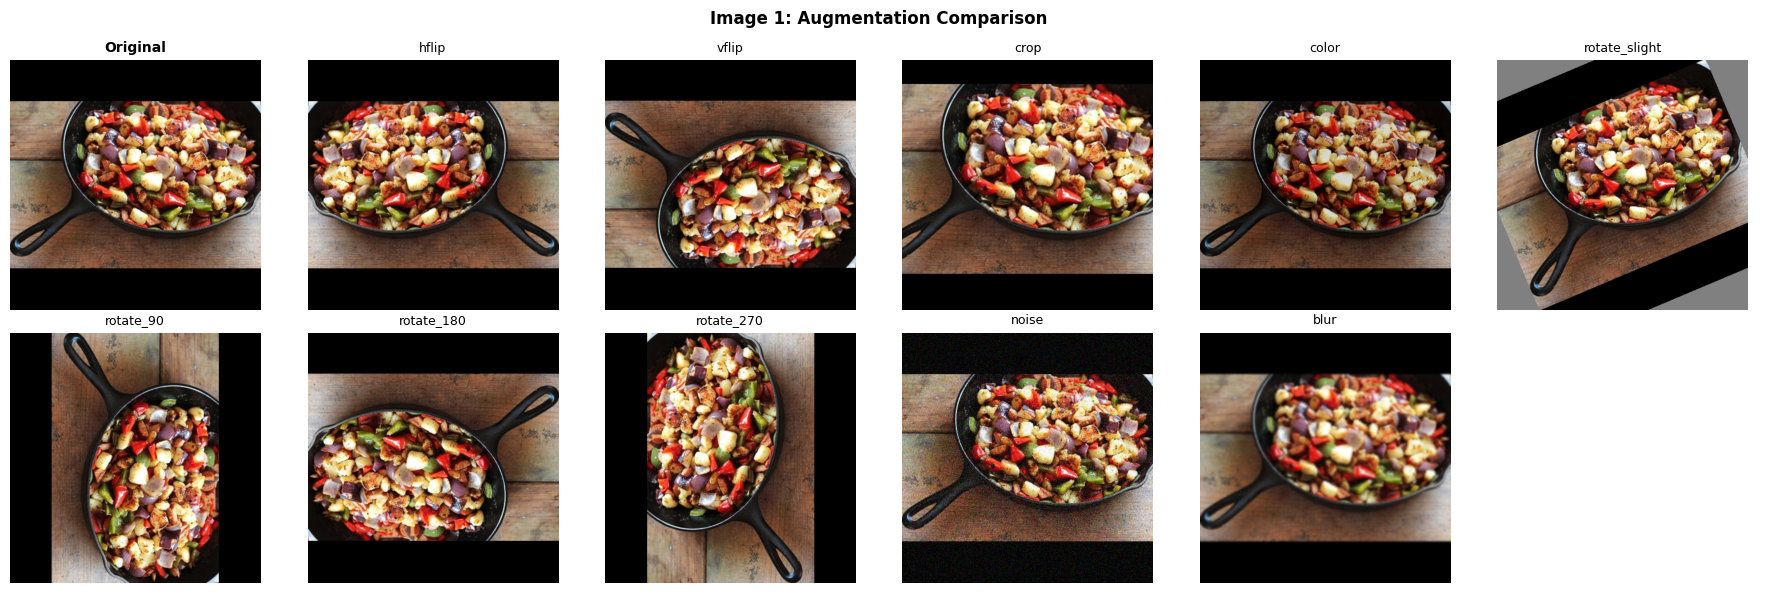

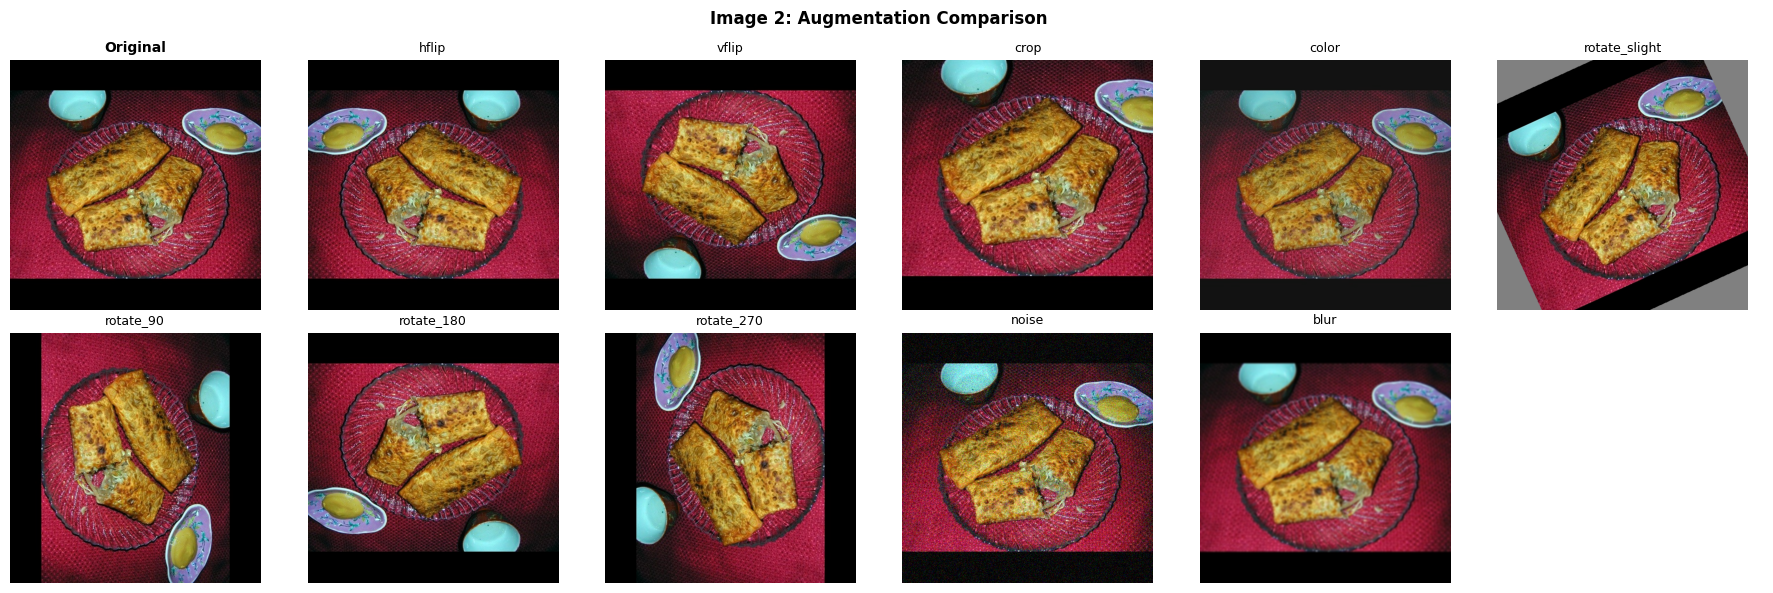

In [64]:
import matplotlib.pyplot as plt

def visualize_image_augmentations(
    df: pd.DataFrame,
    bucket: str,
    n_samples: int = 2,
    augmentations_to_show: List[str] = None,
    cols_per_row: int = 6
):
    """
    Visualize original images alongside their augmented versions.
    
    Args:
        df: DataFrame with image_key column
        bucket: MinIO bucket containing images
        n_samples: Number of sample images to show
        augmentations_to_show: List of augmentation types to display (default: all)
        cols_per_row: Max columns per row for better layout
    """
    if augmentations_to_show is None:
        augmentations_to_show = list(augmenter.augmentations.keys())
    
    # Sample random images
    sample_keys = df["image_key"].sample(min(n_samples, len(df)), random_state=RANDOM_SEED).tolist()
    
    for img_idx, img_key in enumerate(sample_keys):
        # Load original image
        original_img = load_image_from_minio(bucket, img_key)
        if original_img is None:
            print(f"Could not load: {img_key}")
            continue
        
        # Calculate grid layout
        n_total = len(augmentations_to_show) + 1  # +1 for original
        n_cols = min(cols_per_row, n_total)
        n_rows = (n_total + n_cols - 1) // n_cols
        
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(3 * n_cols, 3 * n_rows))
        axes = np.array(axes).flatten()
        
        # Show original
        axes[0].imshow(original_img)
        axes[0].set_title("Original", fontsize=10, fontweight="bold")
        axes[0].axis("off")
        
        # Show each augmentation
        for col_idx, aug_name in enumerate(augmentations_to_show, start=1):
            aug_img = augmenter.augment(original_img.copy(), aug_name)
            axes[col_idx].imshow(aug_img)
            axes[col_idx].set_title(f"{aug_name}", fontsize=9)
            axes[col_idx].axis("off")
        
        # Hide unused axes
        for i in range(n_total, len(axes)):
            axes[i].axis("off")
        
        plt.suptitle(f"Image {img_idx + 1}: Augmentation Comparison", fontsize=12, fontweight="bold")
        plt.tight_layout()
        plt.show()


# Visualize augmentations on sample images
print("=" * 60)
print("IMAGE AUGMENTATION PREVIEW")
print("=" * 60)
print(f"Available augmentations: {list(augmenter.augmentations.keys())}")
print(f"\nEdit 'augmentation_config.yaml' to adjust parameters.\n")

# Show all available augmentations
visualize_image_augmentations(
    train_df, 
    bucket=FINE_TUNING_BUCKET,
    n_samples=2,
    augmentations_to_show=list(augmenter.augmentations.keys()),
    cols_per_row=6
)

## 4. Text Augmentation

Generate light variations of captions using simple NLP transformations:
- Synonym replacement for common food words
- Word order variations (for titles)
- Adding/removing articles and conjunctions

We avoid hallucinating new objects by only applying safe transformations.

In [65]:
class TextAugmenter:
    """
    Rule-based text augmentation for food recipe captions.
    
    All parameters are loaded from the YAML config file for easy tuning.
    Operations are designed to preserve semantic meaning and not introduce
    new ingredients or concepts not present in the original caption.
    """
    
    def __init__(self, config: dict = None):
        """Initialize augmenter with configuration from YAML."""
        self.config = config.get("text_augmentation", {}) if config else {}
        
        # Global settings
        self.max_caption_length = self.config.get("max_caption_length", 150)
        self.augmentations_per_caption = self.config.get("augmentations_per_caption", 2)
        
        # Load operation-specific configs
        self._load_synonym_config()
        self._load_prefix_config()
        self._load_reorder_config()
        self._load_case_config()
        self._load_suffix_config()
        self._load_simplify_config()
        
        # Build list of enabled operations with their probabilities
        self._build_operations_list()
    
    # -------------------------------------------------------------------------
    # CONFIG LOADING METHODS
    # -------------------------------------------------------------------------
    
    def _load_synonym_config(self):
        """Load synonym replacement configuration."""
        cfg = self.config.get("synonym", {})
        self.synonym_enabled = cfg.get("enabled", True)
        self.synonym_prob = cfg.get("probability", 0.4)
        self.synonym_max_replacements = cfg.get("max_replacements", 1)
        self.synonyms = cfg.get("dictionary", {})
    
    def _load_prefix_config(self):
        """Load prefix addition/removal configuration."""
        # Add prefix
        add_cfg = self.config.get("add_prefix", {})
        self.add_prefix_enabled = add_cfg.get("enabled", True)
        self.add_prefix_prob = add_cfg.get("probability", 0.3)
        self.prefixes_to_add = add_cfg.get("prefixes", [
            "Homemade", "Classic", "Easy", "Simple", "Delicious"
        ])
        
        # Remove prefix
        rm_cfg = self.config.get("remove_prefix", {})
        self.remove_prefix_enabled = rm_cfg.get("enabled", True)
        self.remove_prefix_prob = rm_cfg.get("probability", 0.2)
        self.removable_prefixes = rm_cfg.get("removable_prefixes", self.prefixes_to_add)
    
    def _load_reorder_config(self):
        """Load title reordering configuration."""
        cfg = self.config.get("reorder", {})
        self.reorder_enabled = cfg.get("enabled", True)
        self.reorder_prob = cfg.get("probability", 0.3)
        self.dish_keywords = cfg.get("dish_keywords", [
            "Toast", "Pancakes", "Cake", "Soup", "Salad", "Pasta"
        ])
        self.reorder_connector = cfg.get("connector", "with")
    
    def _load_case_config(self):
        """Load case normalization configuration."""
        cfg = self.config.get("case_normalize", {})
        self.case_enabled = cfg.get("enabled", True)
        self.case_prob = cfg.get("probability", 0.2)
        self.target_case = cfg.get("target_case", "title")
    
    def _load_suffix_config(self):
        """Load suffix addition configuration."""
        cfg = self.config.get("add_suffix", {})
        self.suffix_enabled = cfg.get("enabled", True)
        self.suffix_prob = cfg.get("probability", 0.2)
        self.suffixes = cfg.get("suffixes", ["Recipe", "- Easy Recipe"])
    
    def _load_simplify_config(self):
        """Load simplification configuration."""
        cfg = self.config.get("simplify", {})
        self.simplify_enabled = cfg.get("enabled", True)
        self.simplify_prob = cfg.get("probability", 0.25)
    
    def _build_operations_list(self):
        """Build list of enabled operations with probabilities."""
        self.operations = []
        
        if self.synonym_enabled:
            self.operations.append(("synonym", self.synonym_prob, self._synonym_replacement))
        if self.add_prefix_enabled:
            self.operations.append(("add_prefix", self.add_prefix_prob, self._add_prefix))
        if self.remove_prefix_enabled:
            self.operations.append(("remove_prefix", self.remove_prefix_prob, self._remove_prefix))
        if self.reorder_enabled:
            self.operations.append(("reorder", self.reorder_prob, self._reorder_title))
        if self.case_enabled:
            self.operations.append(("case", self.case_prob, self._normalize_case))
        if self.suffix_enabled:
            self.operations.append(("add_suffix", self.suffix_prob, self._add_suffix))
        if self.simplify_enabled:
            self.operations.append(("simplify", self.simplify_prob, self._simplify))
    
    # -------------------------------------------------------------------------
    # AUGMENTATION OPERATIONS
    # -------------------------------------------------------------------------
    
    def _synonym_replacement(self, text: str) -> Optional[str]:
        """
        Replace words with their synonyms from the dictionary.
        Preserves original capitalization.
        """
        words = text.split()
        replaceable = []
        
        for i, word in enumerate(words):
            # Clean word for lookup
            word_clean = word.lower().strip(",.!?()\"'")
            if word_clean in self.synonyms:
                replaceable.append((i, word, word_clean))
        
        if not replaceable:
            return None
        
        # Randomly select words to replace (up to max_replacements)
        n_replace = min(self.synonym_max_replacements, len(replaceable))
        to_replace = random.sample(replaceable, n_replace)
        
        for idx, original, word_clean in to_replace:
            synonym = random.choice(self.synonyms[word_clean])
            # Preserve capitalization
            if original[0].isupper():
                synonym = synonym.capitalize()
            words[idx] = synonym
        
        return " ".join(words)
    
    def _add_prefix(self, text: str) -> Optional[str]:
        """
        Add a descriptive prefix to the caption.
        Skips if caption already starts with a known prefix.
        """
        text_lower = text.lower()
        
        # Check if already has a prefix
        for prefix in self.prefixes_to_add + self.removable_prefixes:
            if text_lower.startswith(prefix.lower()):
                return None
        
        prefix = random.choice(self.prefixes_to_add)
        return f"{prefix} {text}"
    
    def _remove_prefix(self, text: str) -> Optional[str]:
        """
        Remove an existing prefix from the caption.
        Creates a shorter, simpler variant.
        """
        text_lower = text.lower()
        
        # Sort by length (longest first) to match multi-word prefixes first
        sorted_prefixes = sorted(self.removable_prefixes, key=len, reverse=True)
        
        for prefix in sorted_prefixes:
            if text_lower.startswith(prefix.lower()):
                remainder = text[len(prefix):].strip()
                # Ensure we have meaningful content left
                if len(remainder) >= 3:
                    # Re-capitalize first letter
                    return remainder[0].upper() + remainder[1:]
        return None
    
    def _reorder_title(self, text: str) -> Optional[str]:
        """
        Reorder simple "Ingredient + Dish" patterns.
        e.g., "Banana French Toast" → "French Toast with Banana"
        e.g., "Chicken Alfredo Pasta" → "Pasta with Chicken Alfredo"
        """
        words = text.split()
        if len(words) < 2:
            return None
        
        # Look for dish keywords in the caption
        for keyword in self.dish_keywords:
            keyword_lower = keyword.lower()
            
            # Find keyword position (case-insensitive)
            for i, word in enumerate(words):
                if word.lower() == keyword_lower or word.lower().rstrip('s') == keyword_lower.rstrip('s'):
                    # Found dish keyword - check if there's content before it
                    if i > 0:
                        # Split: prefix words + dish keyword + suffix words
                        prefix_words = words[:i]
                        dish_word = words[i]
                        suffix_words = words[i+1:] if i+1 < len(words) else []
                        
                        # Build reordered caption: "Dish [suffix] with Prefix"
                        new_parts = [dish_word] + suffix_words + [self.reorder_connector] + prefix_words
                        result = " ".join(new_parts)
                        
                        # Don't return if result is same or longer
                        if result != text and len(result) <= len(text) + 10:
                            return result
        return None
    
    def _normalize_case(self, text: str) -> Optional[str]:
        """
        Normalize caption casing.
        Options: title, lower, upper
        """
        if self.target_case == "title":
            result = text.title()
        elif self.target_case == "lower":
            result = text.lower()
        elif self.target_case == "upper":
            result = text.upper()
        else:
            return None
        
        # Only return if different from original
        return result if result != text else None
    
    def _add_suffix(self, text: str) -> Optional[str]:
        """
        Add a recipe-style suffix to the caption.
        Skips if caption already ends with a suffix.
        """
        text_lower = text.lower()
        
        # Check if already has a suffix
        for suffix in self.suffixes:
            if text_lower.endswith(suffix.lower().strip()):
                return None
        
        suffix = random.choice(self.suffixes)
        result = f"{text} {suffix}".strip()
        
        # Check length constraint
        if len(result) > self.max_caption_length:
            return None
        return result
    
    def _simplify(self, text: str) -> Optional[str]:
        """
        Remove parenthetical content and numbering.
        e.g., "Chicken Parmesan (Baked)" → "Chicken Parmesan"
        e.g., "Chocolate Cake II" → "Chocolate Cake"
        """
        import re
        
        original = text
        
        # Remove parenthetical content: (anything)
        text = re.sub(r'\s*\([^)]*\)\s*', ' ', text)
        
        # Remove Roman numerals at end: I, II, III, IV, V, etc.
        text = re.sub(r'\s+[IVX]+\s*$', '', text, flags=re.IGNORECASE)
        
        # Remove trailing numbers: "Recipe 2" → "Recipe"
        text = re.sub(r'\s+\d+\s*$', '', text)
        
        # Clean up extra whitespace
        text = ' '.join(text.split())
        
        # Only return if we actually simplified something
        if text != original and len(text) >= 3:
            return text
        return None
    
    # -------------------------------------------------------------------------
    # PUBLIC INTERFACE
    # -------------------------------------------------------------------------
    
    def augment(self, text: str) -> Tuple[Optional[str], str]:
        """
        Apply a random augmentation to the text.
        
        Returns:
            Tuple of (augmented_text, operation_name)
            Returns (None, "") if no valid augmentation could be applied.
        """
        if not self.operations:
            return None, ""
        
        # Shuffle operations and try each based on probability
        shuffled_ops = self.operations.copy()
        random.shuffle(shuffled_ops)
        
        for op_name, prob, op_func in shuffled_ops:
            if random.random() < prob:
                result = op_func(text)
                if result and result != text and len(result) <= self.max_caption_length:
                    return result, op_name
        
        # If probabilistic selection failed, try all operations
        for op_name, _, op_func in shuffled_ops:
            result = op_func(text)
            if result and result != text and len(result) <= self.max_caption_length:
                return result, op_name
        
        return None, ""
    
    def augment_multiple(self, text: str, n: int = None) -> List[Tuple[str, str]]:
        """
        Generate multiple augmented versions of a caption.
        
        Args:
            text: Original caption
            n: Number of augmentations (defaults to config value)
        
        Returns:
            List of (augmented_text, operation_name) tuples
        """
        if n is None:
            n = self.augmentations_per_caption
        
        results = []
        seen = {text}  # Track seen captions to avoid duplicates
        max_attempts = n * 3  # Limit attempts to avoid infinite loops
        attempts = 0
        
        while len(results) < n and attempts < max_attempts:
            aug_text, op_name = self.augment(text)
            if aug_text and aug_text not in seen:
                results.append((aug_text, op_name))
                seen.add(aug_text)
            attempts += 1
        
        return results
    
    def print_config(self):
        """Print current text augmentation configuration."""
        print("Text Augmentation Configuration:")
        print(f"  Max caption length: {self.max_caption_length}")
        print(f"  Augmentations per caption: {self.augmentations_per_caption}")
        print(f"\nEnabled operations:")
        for op_name, prob, _ in self.operations:
            print(f"  - {op_name}: probability={prob:.2f}")
        print(f"\nSynonym dictionary: {len(self.synonyms)} word entries")
        print(f"Prefixes to add: {len(self.prefixes_to_add)} options")
        print(f"Dish keywords for reordering: {len(self.dish_keywords)} keywords")


# Initialize text augmenter with config
text_augmenter = TextAugmenter(config=AUG_CONFIG)
text_augmenter.print_config()

Text Augmentation Configuration:
  Max caption length: 150
  Augmentations per caption: 2

Enabled operations:
  - synonym: probability=0.40
  - add_prefix: probability=0.30
  - remove_prefix: probability=0.20
  - reorder: probability=0.30
  - case: probability=0.20
  - add_suffix: probability=0.20
  - simplify: probability=0.25

Synonym dictionary: 26 word entries
Prefixes to add: 12 options
Dish keywords for reordering: 26 keywords


In [66]:
def create_text_augmentations(
    df: pd.DataFrame,
    augmenter: TextAugmenter,
    n_augmentations: int = None
) -> pd.DataFrame:
    """
    Create text-augmented pairs using the configured TextAugmenter.
    
    Args:
        df: Original training DataFrame
        augmenter: TextAugmenter instance with loaded config
        n_augmentations: Number of augmentations per caption (uses config default if None)
    
    Returns:
        DataFrame with text-augmented pairs including operation type
    """
    if n_augmentations is None:
        n_augmentations = augmenter.augmentations_per_caption
    
    augmented_rows = []
    operation_counts = {}
    
    print(f"Generating up to {n_augmentations} text augmentations per unique caption...")
    
    # Group by unique captions to avoid duplicating work
    unique_captions = df.drop_duplicates(subset=["caption"])
    caption_augmentations = {}  # Maps caption -> list of (aug_text, op_name)
    
    for _, row in unique_captions.iterrows():
        caption = row["caption"]
        # Use the augmenter's multiple augmentation method
        augs = augmenter.augment_multiple(caption, n=n_augmentations)
        caption_augmentations[caption] = augs
        
        # Track operation counts
        for _, op_name in augs:
            operation_counts[op_name] = operation_counts.get(op_name, 0) + 1
    
    # Create augmented rows for all image-caption pairs
    for idx, row in df.iterrows():
        caption = row["caption"]
        augs = caption_augmentations.get(caption, [])
        
        for aug_caption, op_name in augs:
            augmented_rows.append({
                "recipe_id": row["recipe_id"],
                "image_key": row["image_key"],
                "caption": aug_caption,
                "label": 1,
                "augmentation_type": f"text_{op_name}",
            })
    
    aug_df = pd.DataFrame(augmented_rows)
    
    # Report results
    print(f"✓ Generated {len(aug_df)} text-augmented pairs")
    print(f"\nOperations applied:")
    for op_name, count in sorted(operation_counts.items(), key=lambda x: -x[1]):
        print(f"  - {op_name}: {count}")
    
    return aug_df


# Generate text augmentations using config
text_aug_df = create_text_augmentations(
    train_df,
    augmenter=text_augmenter,
    n_augmentations=TEXT_AUGMENTATIONS_PER_SAMPLE
)

if not text_aug_df.empty:
    print(f"\nSample text augmentations:")
    sample = text_aug_df.sample(min(5, len(text_aug_df)), random_state=RANDOM_SEED)
    for _, row in sample.iterrows():
        print(f"  Original: '{row.get('original_caption', 'N/A')}'")
        print(f"  Augmented: '{row['caption']}'")
        print()

Generating up to 1 text augmentations per unique caption...
✓ Generated 372 text-augmented pairs

Operations applied:
  - add_prefix: 70
  - add_suffix: 69
  - reorder: 31
  - synonym: 30
  - case: 11
  - simplify: 4

Sample text augmentations:
  Original: 'N/A'
  Augmented: 'Potato and Smoked Sausage Hash'

  Original: 'N/A'
  Augmented: 'Chicken Egg Rolls with Easy'

  Original: 'N/A'
  Augmented: 'Muffins with Sour Cream Lemon'

  Original: 'N/A'
  Augmented: 'Corn & Coriander Soup'

  Original: 'N/A'
  Augmented: 'Homemade Cola Chocolate Cupcakes'



### 4.1 Visualize Text Augmentations

Compare original captions with their augmented versions to verify the text transformations are reasonable and preserve meaning.

In [67]:
def visualize_text_augmentations(
    df: pd.DataFrame,
    augmenter: TextAugmenter,
    n_samples: int = 10,
    show_all_operations: bool = True
):
    """
    Visualize original captions alongside their augmented versions.
    Shows each operation type explicitly so you can tune parameters.
    
    Args:
        df: DataFrame with caption column
        augmenter: TextAugmenter instance
        n_samples: Number of sample captions to show
        show_all_operations: If True, try each operation individually
    """
    # Sample random captions
    sample_captions = df["caption"].drop_duplicates().sample(
        min(n_samples, df["caption"].nunique()), 
        random_state=RANDOM_SEED
    ).tolist()
    
    print("=" * 80)
    print("TEXT AUGMENTATION PREVIEW")
    print("=" * 80)
    print(f"Edit 'augmentation_config.yaml' to adjust parameters.\n")
    
    for i, caption in enumerate(sample_captions, 1):
        print(f"\n[{i}] Original: \"{caption}\"")
        print("-" * 70)
        
        if show_all_operations:
            # Try each operation explicitly
            results = []
            
            # Synonym replacement
            aug = augmenter._synonym_replacement(caption)
            if aug and aug != caption:
                results.append(("synonym", aug))
            
            # Add prefix
            aug = augmenter._add_prefix(caption)
            if aug and aug != caption:
                results.append(("add_prefix", aug))
            
            # Remove prefix
            aug = augmenter._remove_prefix(caption)
            if aug and aug != caption:
                results.append(("remove_prefix", aug))
            
            # Reorder title
            aug = augmenter._reorder_title(caption)
            if aug and aug != caption:
                results.append(("reorder", aug))
            
            # Case normalize
            aug = augmenter._normalize_case(caption)
            if aug and aug != caption:
                results.append(("case", aug))
            
            # Add suffix
            aug = augmenter._add_suffix(caption)
            if aug and aug != caption:
                results.append(("add_suffix", aug))
            
            # Simplify
            aug = augmenter._simplify(caption)
            if aug and aug != caption:
                results.append(("simplify", aug))
            
            if results:
                for op_name, aug_text in results:
                    print(f"    {op_name:15s}: \"{aug_text}\"")
            else:
                print(f"    (No augmentations applicable)")
        else:
            # Use random selection
            augs = augmenter.augment_multiple(caption, n=4)
            if augs:
                for aug_text, op_name in augs:
                    print(f"    {op_name:15s}: \"{aug_text}\"")
            else:
                print(f"    (No augmentations applicable)")
    
    # Summary
    print("\n" + "=" * 80)
    print("CONFIGURATION SUMMARY")
    print("=" * 80)
    augmenter.print_config()


# Visualize text augmentations
print("Visualizing text augmentations on sample captions...\n")
visualize_text_augmentations(
    train_df, 
    augmenter=text_augmenter,
    n_samples=8,
    show_all_operations=True
)

Visualizing text augmentations on sample captions...

TEXT AUGMENTATION PREVIEW
Edit 'augmentation_config.yaml' to adjust parameters.


[1] Original: "Strawberry Rhubarb Dump Cake"
----------------------------------------------------------------------
    add_prefix     : "Homemade Strawberry Rhubarb Dump Cake"
    reorder        : "Cake with Strawberry Rhubarb Dump"
    add_suffix     : "Strawberry Rhubarb Dump Cake - Easy Recipe"

[2] Original: "Popcorn Granola"
----------------------------------------------------------------------
    add_prefix     : "Authentic Popcorn Granola"
    add_suffix     : "Popcorn Granola (Quick & Easy)"

[3] Original: "Banana Cream Pie Smoothie"
----------------------------------------------------------------------
    add_prefix     : "Perfect Banana Cream Pie Smoothie"
    reorder        : "Pie Smoothie with Banana Cream"
    add_suffix     : "Banana Cream Pie Smoothie - Easy Recipe"

[4] Original: "Balsamic Fig Cheese Spread"
-------------------------

## 5. Negative Pair Generation

Generate negative examples by mismatching images and captions from different recipes.

Rules:
- For each image, select captions from different recipe_ids
- Ensure no accidental positives (same recipe)
- Only generate negatives for training data

In [68]:
def generate_negative_pairs(
    df: pd.DataFrame,
    negatives_per_positive: int = 1
) -> pd.DataFrame:
    """
    Generate negative pairs by mismatching images and captions.
    
    Args:
        df: Original training DataFrame
        negatives_per_positive: Number of negative pairs per original pair
    
    Returns:
        DataFrame with negative pairs (label=0)
    """
    negative_rows = []
    
    # Get unique captions per recipe
    recipe_captions = df.groupby("recipe_id")["caption"].first().to_dict()
    recipe_ids = list(recipe_captions.keys())
    
    print(f"Generating {negatives_per_positive} negative pairs per image...")
    print(f"  Total images: {len(df)}")
    print(f"  Unique recipes: {len(recipe_ids)}")
    
    for idx, row in df.iterrows():
        current_recipe = row["recipe_id"]
        current_image = row["image_key"]
        
        # Get candidate recipes (different from current)
        candidate_recipes = [r for r in recipe_ids if r != current_recipe]
        
        if len(candidate_recipes) < negatives_per_positive:
            # If not enough candidates, use all available
            selected_recipes = candidate_recipes
        else:
            # Randomly select recipes for negative pairing
            selected_recipes = random.sample(candidate_recipes, negatives_per_positive)
        
        for neg_recipe in selected_recipes:
            negative_rows.append({
                "recipe_id": current_recipe,  # Keep original recipe_id for reference
                "image_key": current_image,
                "caption": recipe_captions[neg_recipe],  # Caption from different recipe
                "label": 0,
                "augmentation_type": "negative_mismatch",
                "mismatched_recipe_id": neg_recipe
            })
    
    neg_df = pd.DataFrame(negative_rows)
    print(f"✓ Generated {len(neg_df)} negative pairs")
    
    # Verify no accidental positives
    accidental_positives = neg_df[neg_df["recipe_id"] == neg_df.get("mismatched_recipe_id", "")]
    if len(accidental_positives) > 0:
        print(f"⚠ Warning: Found {len(accidental_positives)} accidental positives, removing...")
        neg_df = neg_df[neg_df["recipe_id"] != neg_df.get("mismatched_recipe_id", "")]
    
    return neg_df

# Generate negative pairs
negative_df = generate_negative_pairs(
    train_df,
    negatives_per_positive=NEGATIVES_PER_POSITIVE
)

print(f"\nSample negative pairs:")
sample_neg = negative_df.sample(min(5, len(negative_df)), random_state=RANDOM_SEED)
for _, row in sample_neg.iterrows():
    print(f"  Image from recipe: {row['recipe_id']}")
    print(f"  Caption from recipe: {row.get('mismatched_recipe_id', 'N/A')}")
    print(f"  Caption: '{row['caption'][:50]}...'")
    print()

Generating 1 negative pairs per image...
  Total images: 372
  Unique recipes: 216
✓ Generated 372 negative pairs

Sample negative pairs:
  Image from recipe: 001128ebd8
  Caption from recipe: 001ab60ef2
  Caption: 'Muffins Basic and Variations...'

  Image from recipe: 00274c3c21
  Caption from recipe: 0041f3b796
  Caption: 'Marshmallow Treats...'

  Image from recipe: 002fd94c16
  Caption from recipe: 0030330616
  Caption: 'Lilly Belle's Strawberry Pudding...'

  Image from recipe: 0025ca4eef
  Caption from recipe: 000dfc842f
  Caption: 'Hot Fudge Pudding Cake II...'

  Image from recipe: 0041a58ee5
  Caption from recipe: 002c0bbd96
  Caption: 'Goan Prawn Curry...'



## 6. Combine All Data

In [69]:
# Prepare original positive pairs with label=1
original_df = train_df.copy()
original_df["label"] = 1
original_df["augmentation_type"] = "original"

# Select only the columns we need for the final dataset
final_columns = ["recipe_id", "image_key", "caption", "label"]

# Combine all DataFrames
all_dfs = [original_df[final_columns]]

if not image_aug_df.empty:
    all_dfs.append(image_aug_df[final_columns])

if not text_aug_df.empty:
    all_dfs.append(text_aug_df[final_columns])

if not negative_df.empty:
    all_dfs.append(negative_df[final_columns])

combined_df = pd.concat(all_dfs, ignore_index=True)

# Shuffle the dataset
combined_df = combined_df.sample(frac=1, random_state=RANDOM_SEED).reset_index(drop=True)

print("=" * 60)
print("Combined Dataset Summary")
print("=" * 60)
print(f"\nTotal samples: {len(combined_df)}")
print(f"\nLabel distribution:")
print(combined_df["label"].value_counts())
print(f"\nPositive/Negative ratio: {combined_df['label'].mean():.2%} positive")
print(f"\nUnique recipes: {combined_df['recipe_id'].nunique()}")
print(f"Unique images: {combined_df['image_key'].nunique()}")
print(f"Unique captions: {combined_df['caption'].nunique()}")

print(f"\nSample rows:")
display(combined_df.head(10))

Combined Dataset Summary

Total samples: 1860

Label distribution:
label
1    1488
0     372
Name: count, dtype: int64

Positive/Negative ratio: 80.00% positive

Unique recipes: 216
Unique images: 1116
Unique captions: 430

Sample rows:


,recipe_id,image_key,caption,label
0,0016f38e7e,images/image$adsdb-multimodal-food-data-manage...,Melon Mint White Sangria,1
1,00274c3c21,augmented_images/image$adsdb-multimodal-food-d...,Easy Chicken Egg Rolls,1
2,000dfc842f,images/image$adsdb-multimodal-food-data-manage...,Quick Hot Fudge Pudding Cake II,1
3,002e397368,images/image$adsdb-multimodal-food-data-manage...,Brussels Sprouts With Bacon & Apple,1
4,002481e577,augmented_images/image$adsdb-multimodal-food-d...,Quick & Easy Chicken Parmigiana,1
5,00236ff903,images/image$adsdb-multimodal-food-data-manage...,Broiled Eggplant featuring Cilantro Vinaigrette,1
6,0044818076,images/image$adsdb-multimodal-food-data-manage...,Cornmeal Mush,0
7,00404a729c,images/image$adsdb-multimodal-food-data-manage...,Cinnamon Apricot Ice Cream Topping Recipe,1
8,0032a590b1,images/image$adsdb-multimodal-food-data-manage...,Fresh Cranberry Sauce,1
9,0032a590b1,images/image$adsdb-multimodal-food-data-manage...,Fresh Cranberry Sauce,1


## 7. Save to MinIO

In [70]:
def save_csv_to_minio(df: pd.DataFrame, bucket: str, key: str) -> bool:
    """Save DataFrame as CSV to MinIO."""
    try:
        csv_buffer = io.StringIO()
        df.to_csv(csv_buffer, index=False, encoding="utf-8")
        csv_bytes = csv_buffer.getvalue().encode("utf-8")
        
        s3.put_object(
            Bucket=bucket,
            Key=key,
            Body=csv_bytes,
            ContentType="text/csv",
            Metadata={
                "rows": str(len(df)),
                "positive_samples": str(len(df[df["label"] == 1])),
                "negative_samples": str(len(df[df["label"] == 0])),
                "random_seed": str(RANDOM_SEED),
            }
        )
        
        size_kb = len(csv_bytes) / 1024
        print(f"✓ Saved to s3://{bucket}/{key} ({size_kb:.1f} KB)")
        return True
    except Exception as e:
        print(f"✗ Failed to save: {e}")
        return False

# Save the combined dataset
print("=" * 60)
print("Saving Augmented Dataset to MinIO")
print("=" * 60)

if ensure_bucket_exists(FINE_TUNING_BUCKET):
    save_csv_to_minio(combined_df, FINE_TUNING_BUCKET, OUTPUT_KEY)
    print(f"\n✅ Dataset saved to: s3://{FINE_TUNING_BUCKET}/{OUTPUT_KEY}")
else:
    print("✗ Could not access fine-tuning bucket")

Saving Augmented Dataset to MinIO
✓ Saved to s3://fine-tuning-zone/datasets/train_pairs_augmented_with_negatives.csv (320.8 KB)

✅ Dataset saved to: s3://fine-tuning-zone/datasets/train_pairs_augmented_with_negatives.csv


In [71]:
# Final summary
print("\n" + "=" * 60)
print("Dataset Augmentation Complete")
print("=" * 60)

print(f"\n📊 Dataset Statistics:")
print(f"   Original positive pairs: {len(train_df)}")
print(f"   Image-augmented pairs: {len(image_aug_df)}")
print(f"   Text-augmented pairs: {len(text_aug_df)}")
print(f"   Negative pairs: {len(negative_df)}")
print(f"   ──────────────────────────")
print(f"   Total samples: {len(combined_df)}")

print(f"\n📁 Output Location:")
print(f"   s3://{FINE_TUNING_BUCKET}/{OUTPUT_KEY}")

print(f"\n⚙️ Configuration Used:")
print(f"   Random seed: {RANDOM_SEED}")
print(f"   Image augmentations per sample: {IMAGE_AUGMENTATIONS_PER_SAMPLE}")
print(f"   Text augmentations per sample: {TEXT_AUGMENTATIONS_PER_SAMPLE}")
print(f"   Negatives per positive: {NEGATIVES_PER_POSITIVE}")

print(f"\n✅ Ready for CLIP fine-tuning!")


Dataset Augmentation Complete

📊 Dataset Statistics:
   Original positive pairs: 372
   Image-augmented pairs: 744
   Text-augmented pairs: 372
   Negative pairs: 372
   ──────────────────────────
   Total samples: 1860

📁 Output Location:
   s3://fine-tuning-zone/datasets/train_pairs_augmented_with_negatives.csv

⚙️ Configuration Used:
   Random seed: 42
   Image augmentations per sample: 2
   Text augmentations per sample: 1
   Negatives per positive: 1

✅ Ready for CLIP fine-tuning!


## 8. Verify Saved Data

In [72]:
# Verify by loading the saved file
print("Verifying saved dataset...")
verified_df = load_csv_from_minio(FINE_TUNING_BUCKET, OUTPUT_KEY)

if not verified_df.empty:
    print(f"\n✓ Verification successful!")
    print(f"  Rows: {len(verified_df)}")
    print(f"  Columns: {list(verified_df.columns)}")
    print(f"  Label distribution:")
    print(f"    Positive (1): {len(verified_df[verified_df['label'] == 1])}")
    print(f"    Negative (0): {len(verified_df[verified_df['label'] == 0])}")
    
    print(f"\nPreview:")
    display(verified_df.head(10))
else:
    print("✗ Verification failed - could not load saved file")

Verifying saved dataset...
✓ Loaded 1860 rows from s3://fine-tuning-zone/datasets/train_pairs_augmented_with_negatives.csv

✓ Verification successful!
  Rows: 1860
  Columns: ['recipe_id', 'image_key', 'caption', 'label']
  Label distribution:
    Positive (1): 1488
    Negative (0): 372

Preview:


,recipe_id,image_key,caption,label
0,0016f38e7e,images/image$adsdb-multimodal-food-data-manage...,Melon Mint White Sangria,1
1,00274c3c21,augmented_images/image$adsdb-multimodal-food-d...,Easy Chicken Egg Rolls,1
2,000dfc842f,images/image$adsdb-multimodal-food-data-manage...,Quick Hot Fudge Pudding Cake II,1
3,002e397368,images/image$adsdb-multimodal-food-data-manage...,Brussels Sprouts With Bacon & Apple,1
4,002481e577,augmented_images/image$adsdb-multimodal-food-d...,Quick & Easy Chicken Parmigiana,1
5,00236ff903,images/image$adsdb-multimodal-food-data-manage...,Broiled Eggplant featuring Cilantro Vinaigrette,1
6,0044818076,images/image$adsdb-multimodal-food-data-manage...,Cornmeal Mush,0
7,00404a729c,images/image$adsdb-multimodal-food-data-manage...,Cinnamon Apricot Ice Cream Topping Recipe,1
8,0032a590b1,images/image$adsdb-multimodal-food-data-manage...,Fresh Cranberry Sauce,1
9,0032a590b1,images/image$adsdb-multimodal-food-data-manage...,Fresh Cranberry Sauce,1
